In [733]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [734]:
#Load sales of smartphones in India (Rupee)
data = pd.read_csv("Sales.csv")
data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


In [735]:
data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                  object
Storage                 object
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

In [736]:
data.describe()

,Rating,Selling Price,Original Price,Discount,discount percentage
count,2970.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,4.243098,26436.625562,28333.473025,1896.847463,6.086788
std,0.271991,30066.892622,31525.599889,5337.126176,11.106776
min,2.300000,1000.000000,1000.000000,-8000.000000,-160.320641
25%,4.100000,9990.000000,10030.250000,0.000000,0.000000
50%,4.300000,15000.000000,16889.500000,0.000000,0.000000
75%,4.400000,28999.000000,31500.000000,2000.000000,9.836388
max,5.000000,179900.000000,189999.000000,75000.000000,70.610305


In [737]:
data.shape

(3114, 12)

<Axes: >

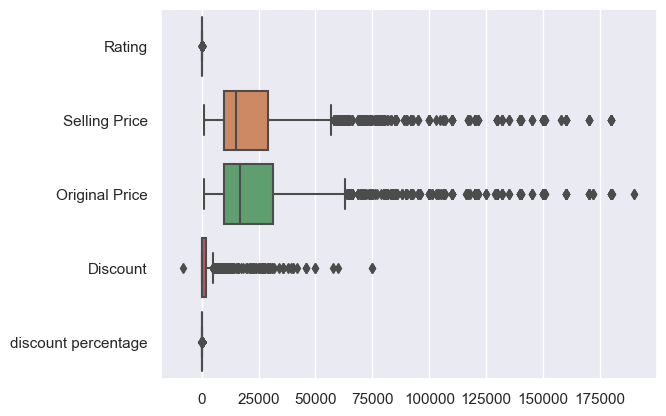

In [738]:
sb.boxplot(data=data, orient="h")

<Axes: xlabel='Original Price', ylabel='Density'>

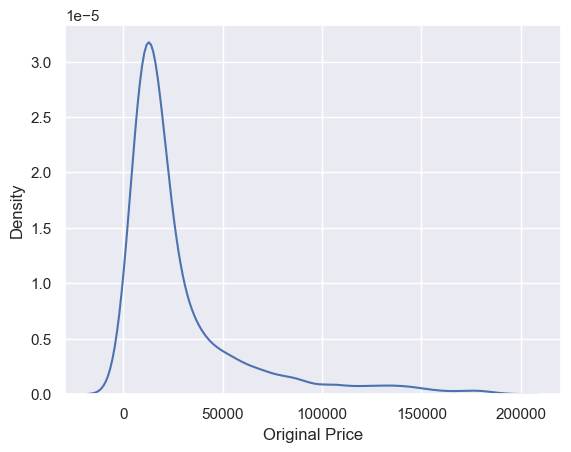

In [739]:
sb.kdeplot(data=data["Original Price"])

Number of outliers in Original Selling Price: 345


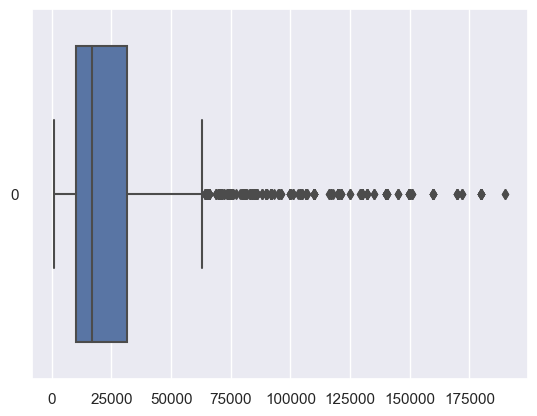

In [740]:
sb.boxplot(data=data['Original Price'], orient="h")

#Calculate outliers
Q1 = data['Original Price'].quantile(0.25)
Q3 = data['Original Price'].quantile(0.75)

IQR = Q3-Q1

lowerBound = Q1-(1.5*IQR)
upperBound = Q3+(1.5*IQR)

#identify all outliers

outliers = data[(data['Original Price'] < lowerBound) | (data['Original Price']> upperBound)]

print("Number of outliers in Original Selling Price: {}".format(len(outliers)))

df = df.query("Brands == 'Apple'")

<Axes: >

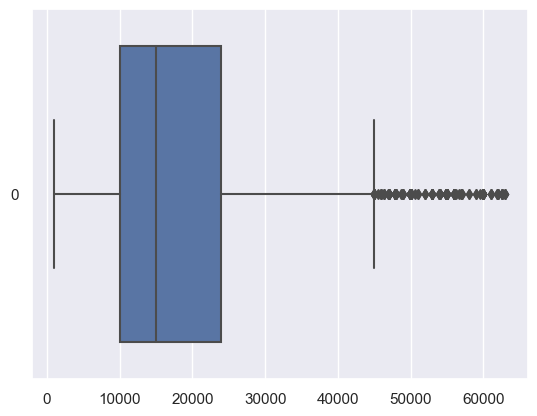

In [741]:
#Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    
    lowerBound = Q1-(1.5*IQR)
    upperBound = Q3+(1.5*IQR)
    
    df_filtered = df.loc[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    
    return df_filtered


# Remove outliers in the original selling price
filtered_data = remove_outliers(data, "Original Price")
#df[df['Brands'].str.contains("Apple")].head(400)
sb.boxplot(data=filtered_data["Original Price"], orient="h")


In [742]:
#Count the number of null values in the data
filtered_data.isna().sum()

Brands                  0
Models                  0
Colors                  0
Memory                 29
Storage                36
Camera                  0
Rating                 85
Selling Price           0
Original Price          0
Mobile                  0
Discount                0
discount percentage     0
dtype: int64

In [743]:
#Remove all the null values in the data
filtered_data = filtered_data.dropna()

In [744]:
#After the removal of null values
filtered_data.shape

(2625, 12)

In [745]:
filtered_data['Storage'] = filtered_data['Storage'].str.replace("Expandable Upto", "")

In [746]:
#filtered_data["Memory"] = filtered_data['Memory'].str.replace('GB', " GB")
#filtered_data = filtered_data.reset_index()

#Convert to GB
def convert_to_gb(size_str):
    if "MB" in size_str:
        return float(size_str.replace("MB", "")) / 1000
    elif "TB" in size_str:
        return float(size_str.replace("TB", "")) * 1000
    elif "GB" in size_str:
        return float(size_str.replace("GB", ""))
    else:
        return None


filtered_data["Memory"] = filtered_data['Memory'].apply(convert_to_gb)
filtered_data['Storage'] = filtered_data['Storage'].apply(convert_to_gb)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,2199,GIONEE L800,0,0.000000


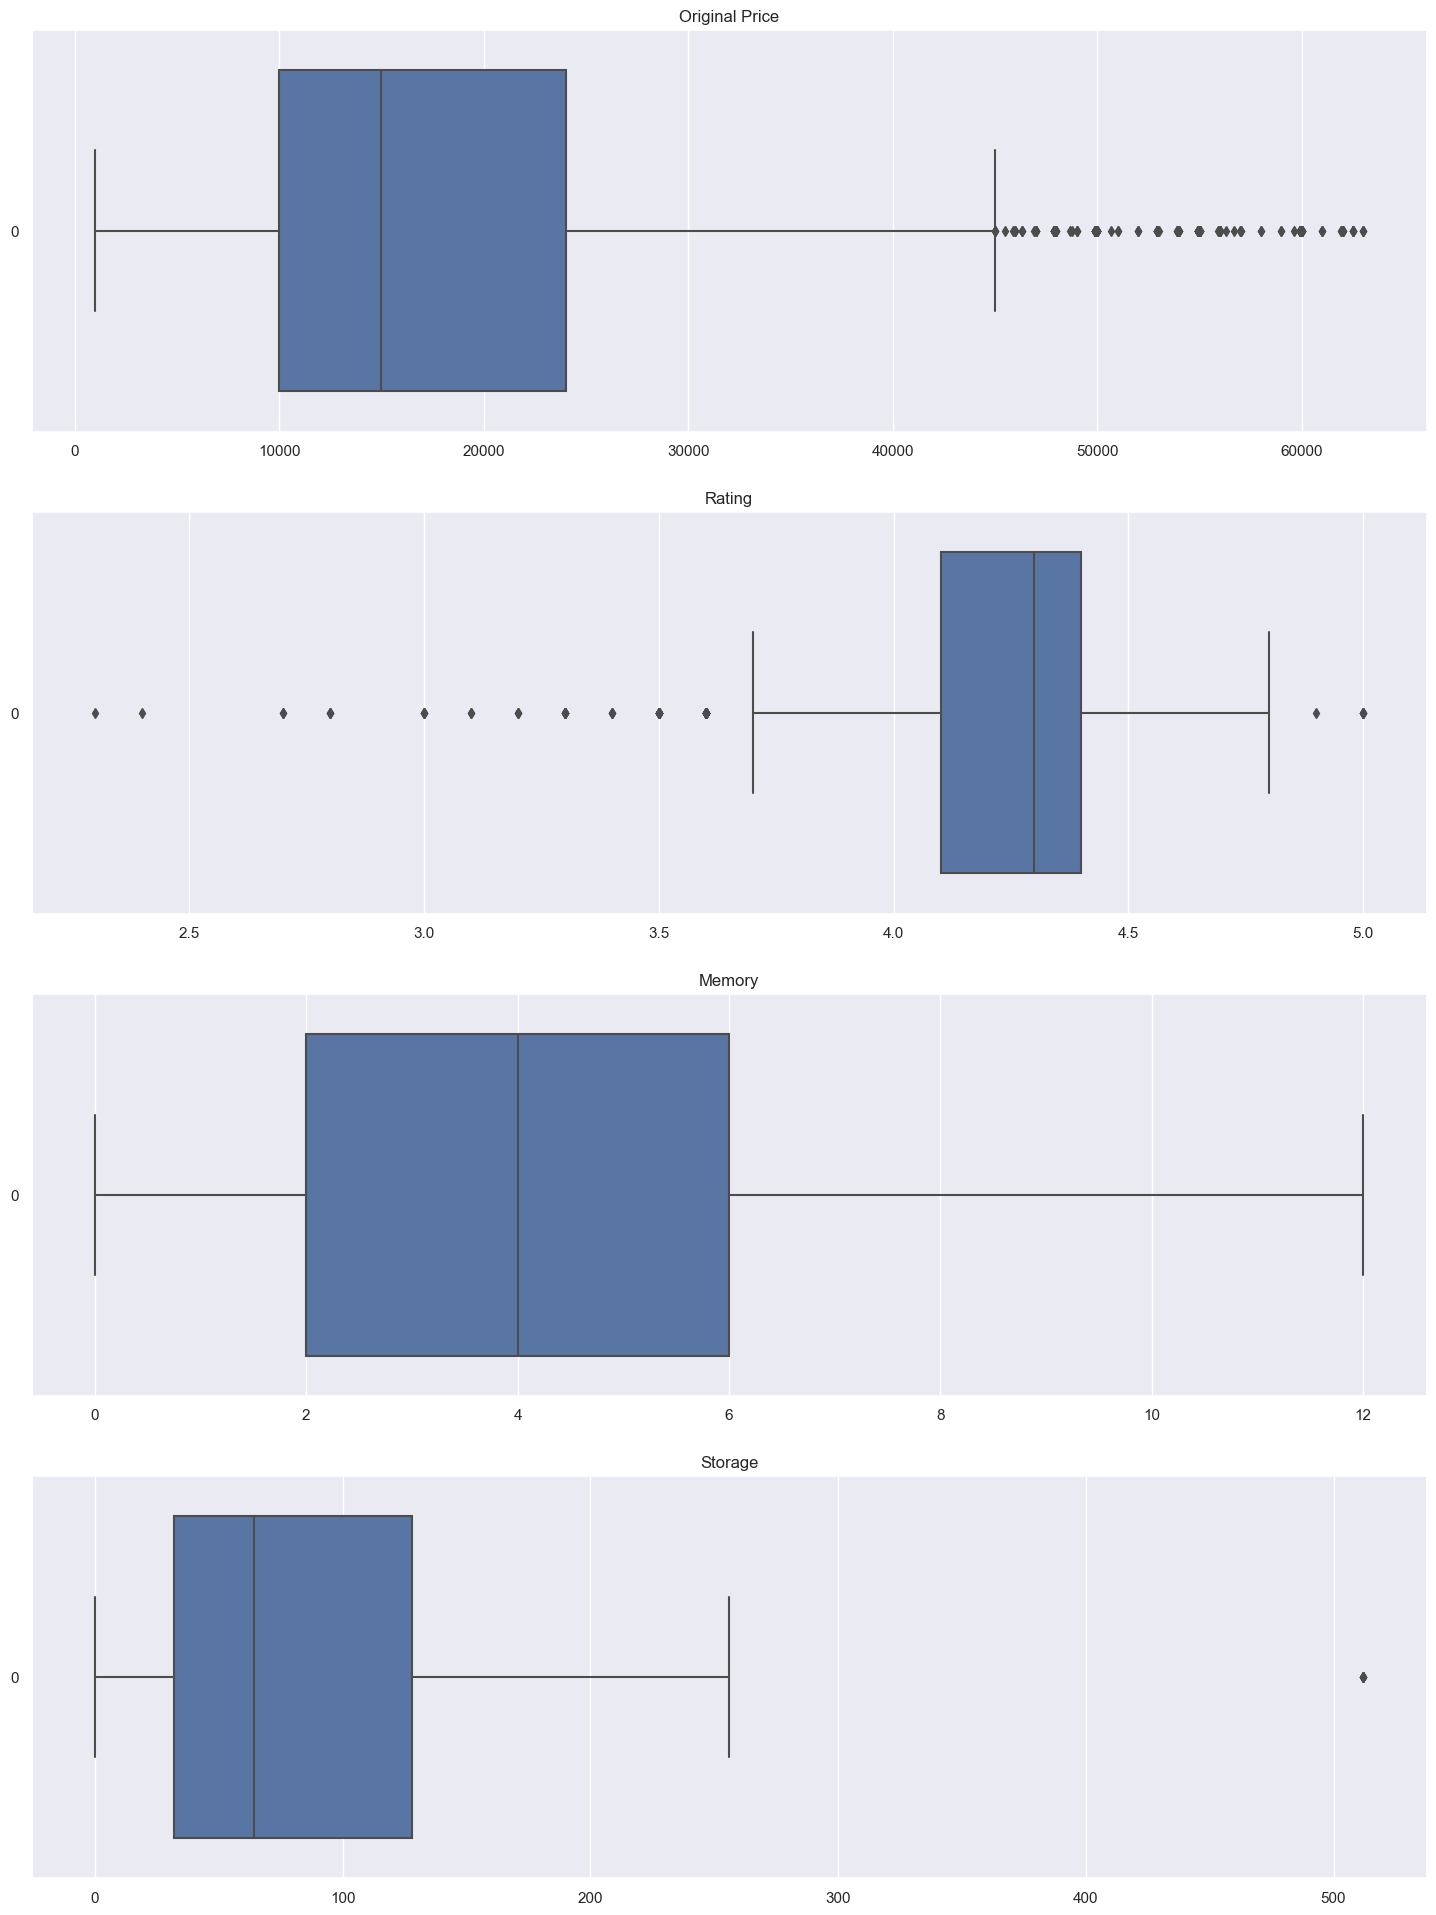

In [747]:
var = ["Original Price", "Rating", "Memory", "Storage"]
count = 0

f, axes = plt.subplots(4,figsize=(18,24))
for var in numeric_data:
    sb.boxplot(data = numeric_data[var], orient="h", ax = axes[count]).set_title(var)
    count+=1

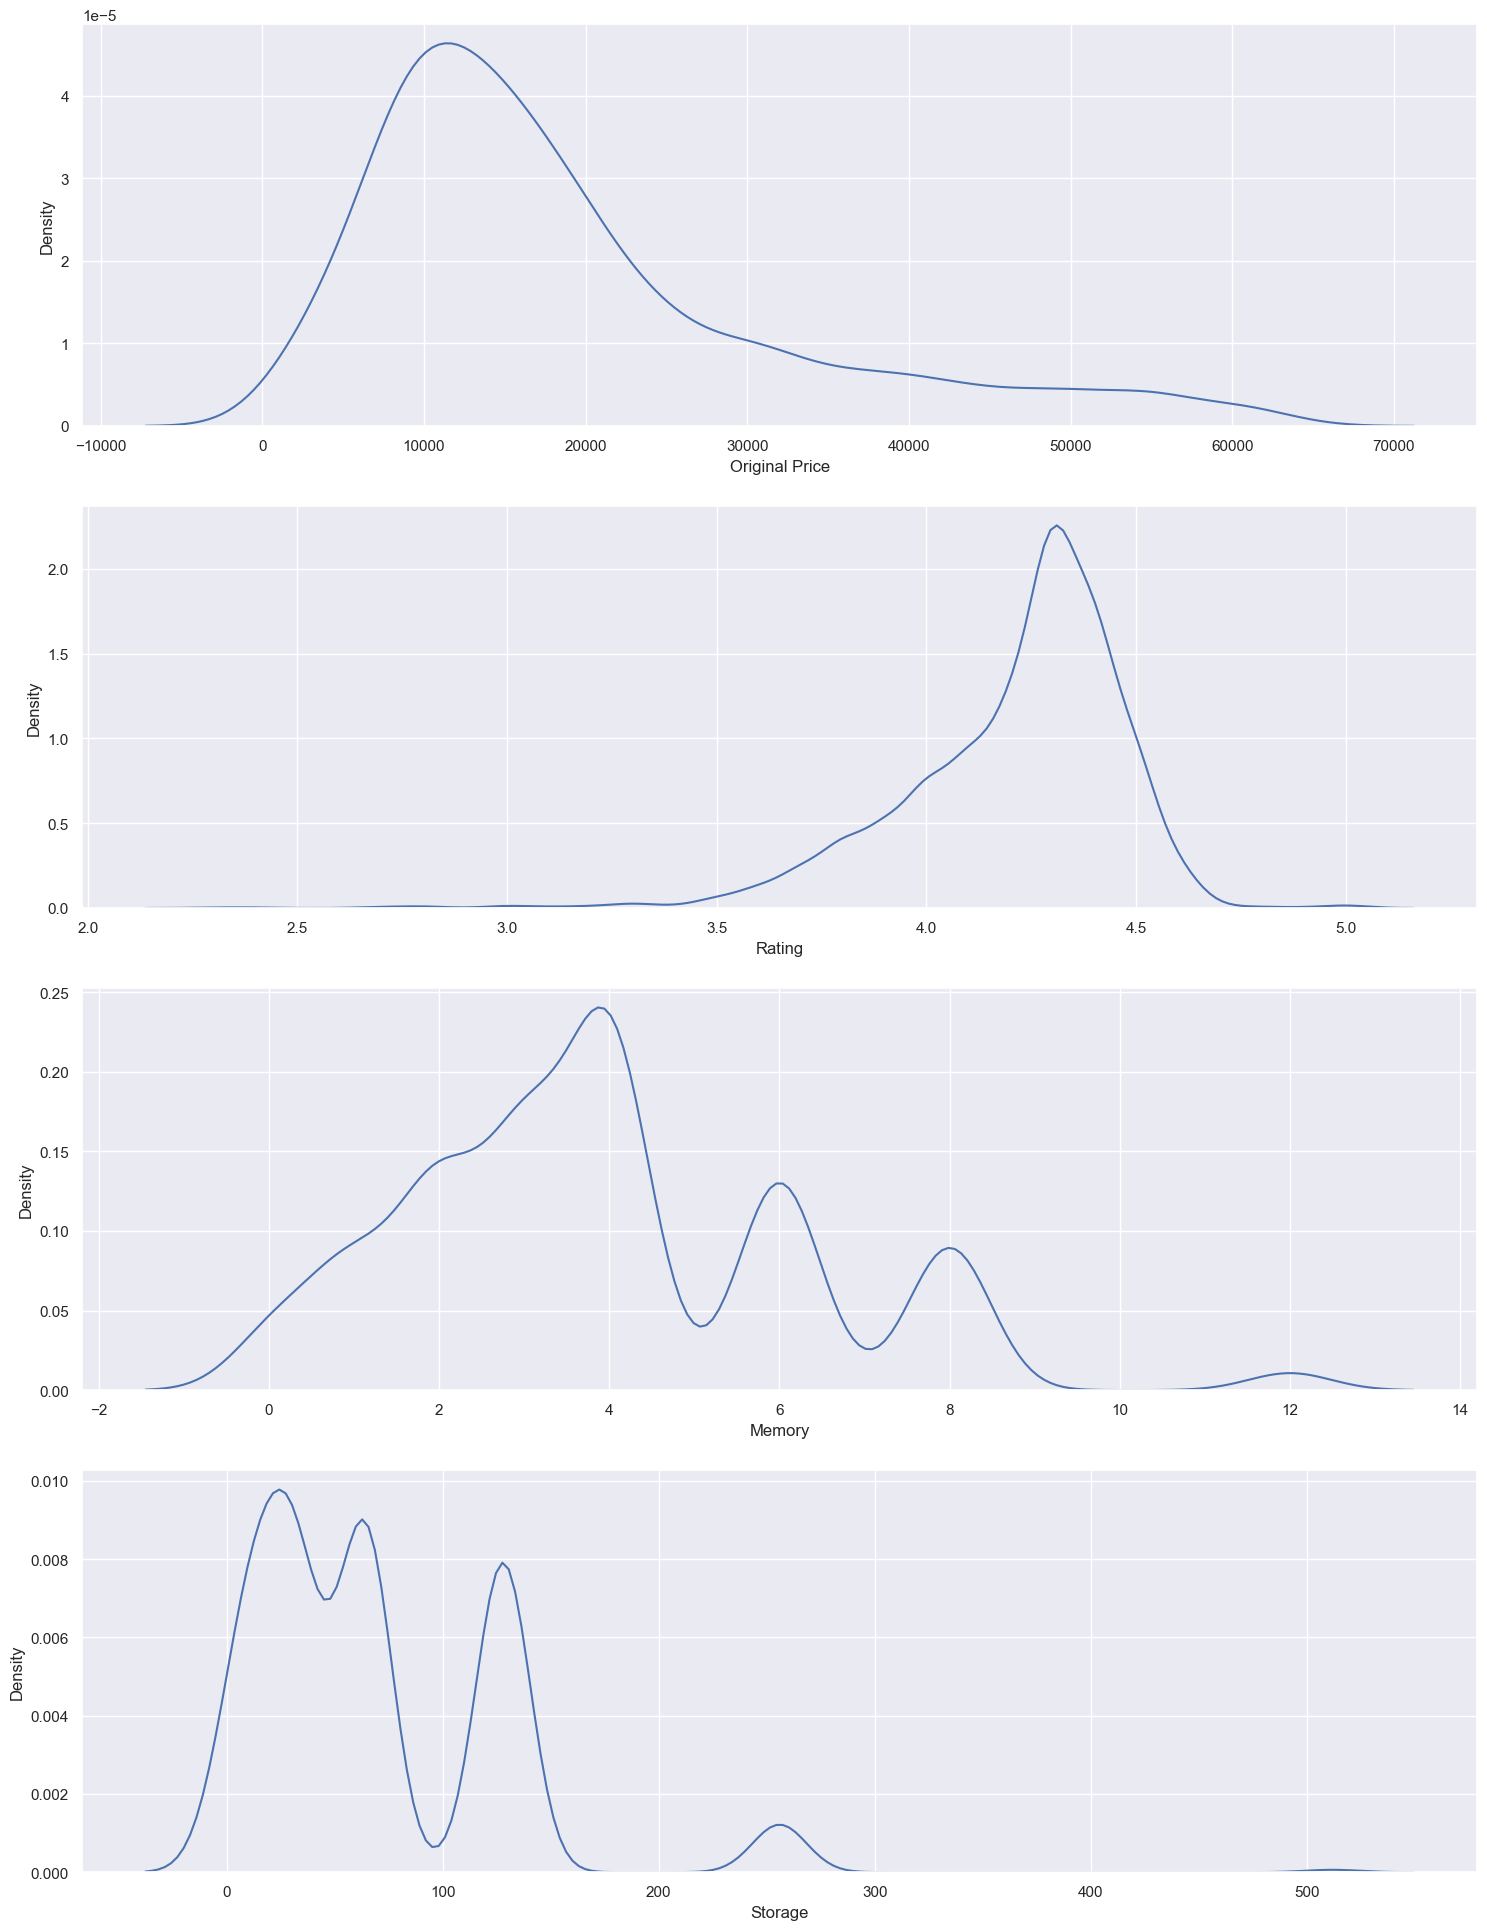

In [748]:
f, axes = plt.subplots(4,figsize=(18,24))
count = 0
for var in numeric_data:
    sb.kdeplot(data=filtered_data[var], ax = axes[count])
    count+=1

Rating            0.417703
Memory            0.467205
Storage           0.540914
Original Price    1.000000
Name: Original Price, dtype: float64


<Axes: >

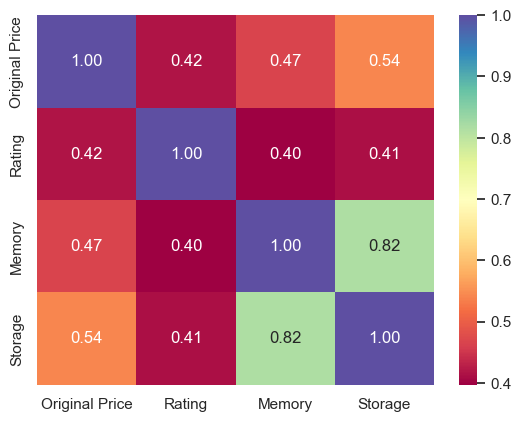

In [749]:
numeric_data = pd.DataFrame(filtered_data[["Original Price","Rating", "Memory", "Storage"]])
corr = numeric_data.corr()
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')


Coefficients of Regression: 117.70296219191277
Intercept of Regression: 10954.969287934658


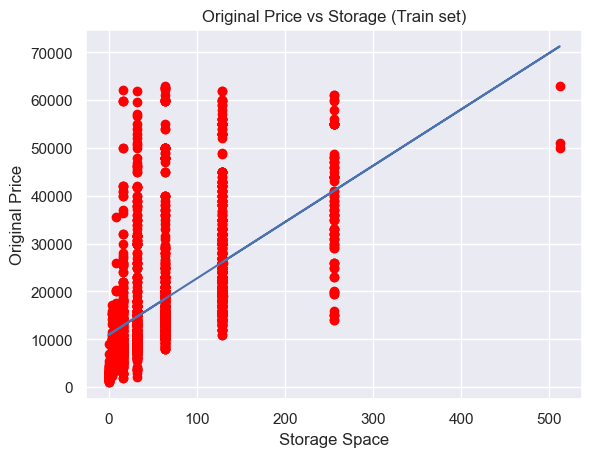

In [750]:
#Linear  Regression
storage = filtered_data[['Storage']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
storage_train, storage_test, originalPrice_train, originalPrice_test = train_test_split(storage, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(storage_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(storage_train, originalPrice_train, color='red')
plt.plot(storage_train, linreg.predict(storage_train))
plt.title("Original Price vs Storage (Train set)")
plt.xlabel('Storage Space')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.29091570147478973
Mean Squared Error (MSE): 124082694.43903439

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.29903461901010087
Mean Squared Error (MSE): 124470110.44939299


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

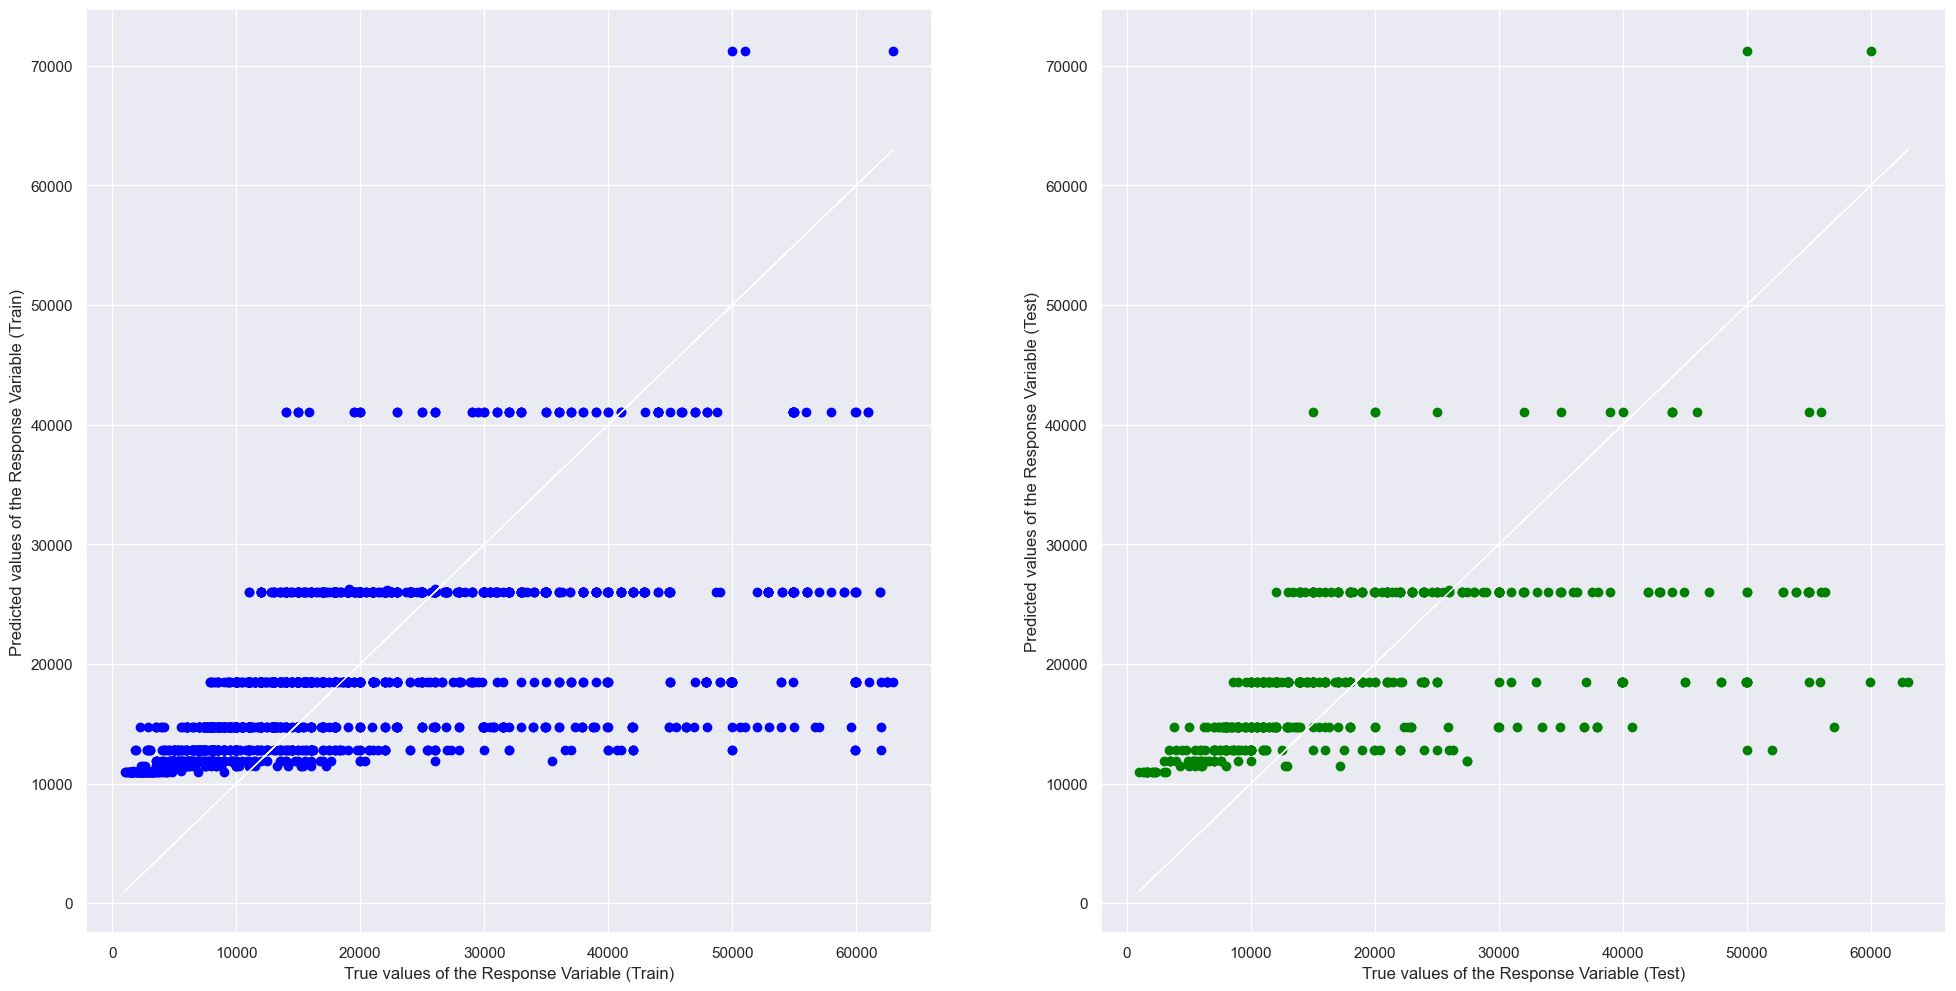

In [751]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(storage_test)
originalPrice_train_pred = linreg.predict(storage_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 2540.8327449703065
Intercept of Regression: 9143.2590151879


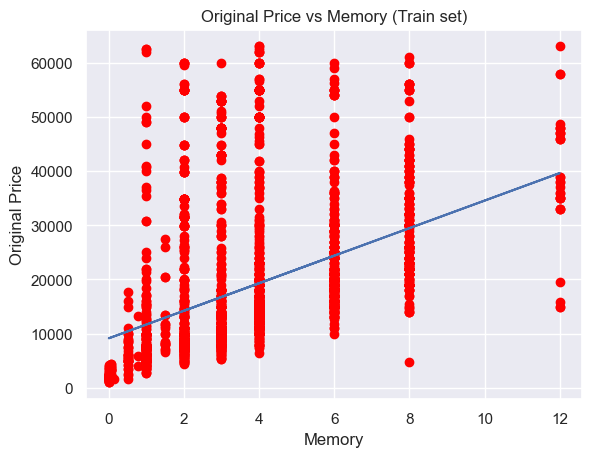

In [752]:
#Linear  Regression
memory = filtered_data[['Memory']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
memory_train, memory_test, originalPrice_train, originalPrice_test = train_test_split(memory, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(memory_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(memory_train, originalPrice_train, color='red')
plt.plot(memory_train, linreg.predict(memory_train))
plt.title("Original Price vs Memory (Train set)")
plt.xlabel('Memory')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.20337299889286742
Mean Squared Error (MSE): 139029425.29122162

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.2741483439598529
Mean Squared Error (MSE): 130171033.02545482


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

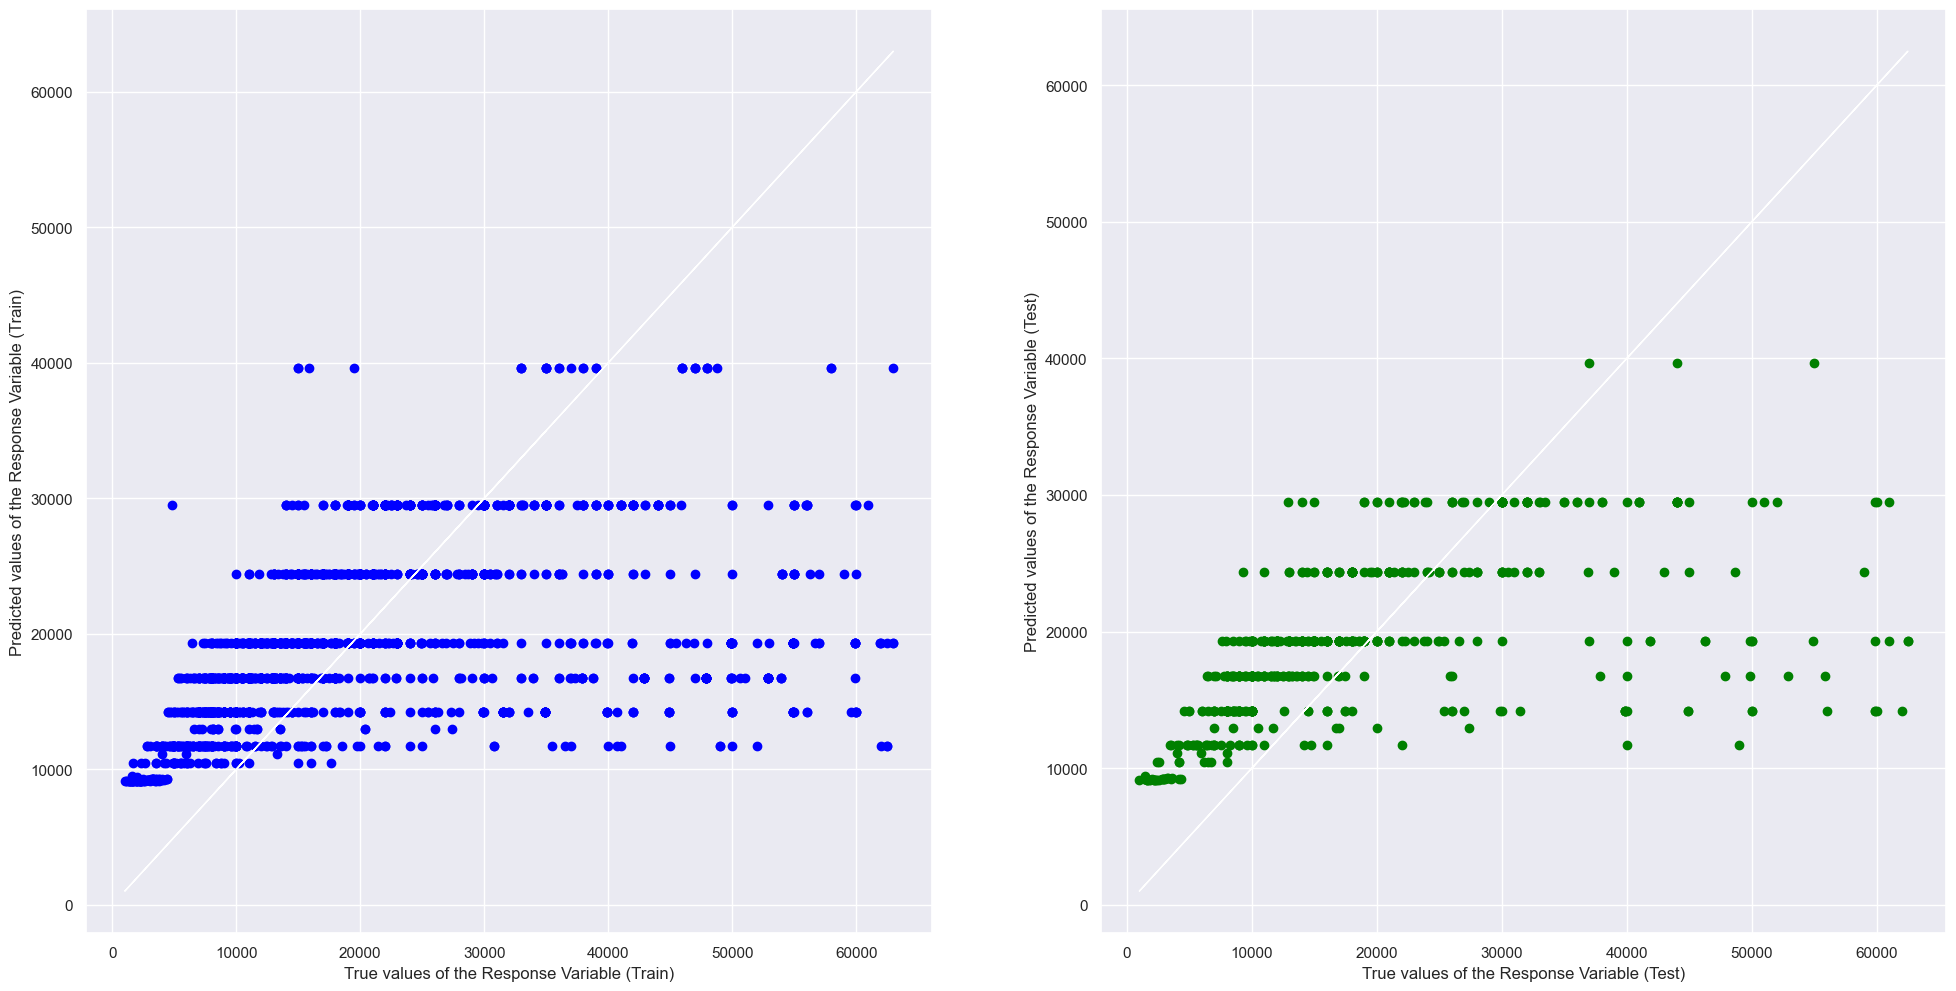

In [753]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(memory_test)
originalPrice_train_pred = linreg.predict(memory_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 22888.87109373035
Intercept of Regression: -77277.15058529656


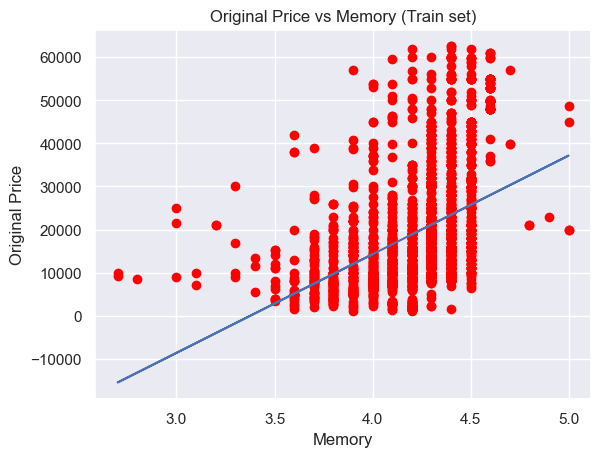

In [754]:
#Linear  Regression
rating = filtered_data[['Rating']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
rating_train, rating_test, originalPrice_train, originalPrice_test = train_test_split(rating, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(rating_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(rating_train, originalPrice_train, color='red')
plt.plot(rating_train, linreg.predict(rating_train))
plt.title("Original Price vs Memory (Train set)")
plt.xlabel('Memory')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.18826321207072294
Mean Squared Error (MSE): 143536899.29531786

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.10869440373370509
Mean Squared Error (MSE): 151261119.04122707


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

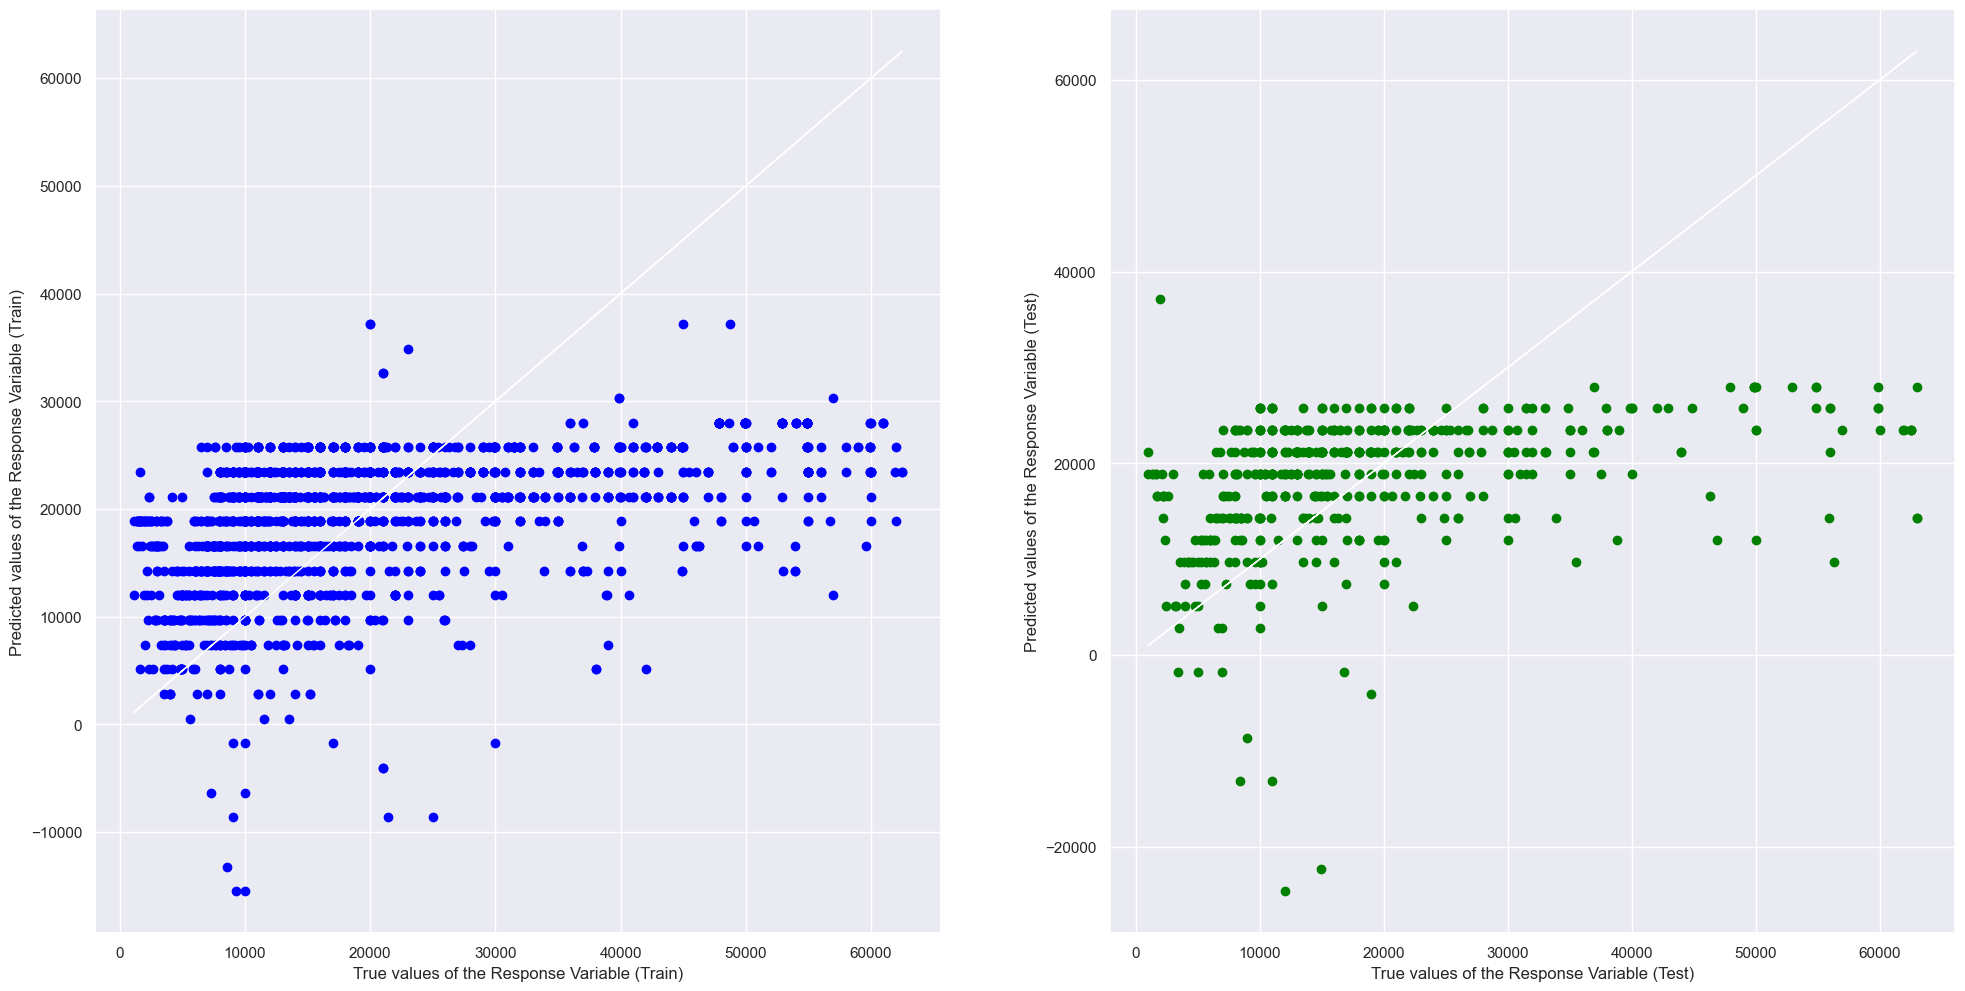

In [755]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(rating_test)
originalPrice_train_pred = linreg.predict(rating_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

<Axes: xlabel='Original Price', ylabel='Brands'>

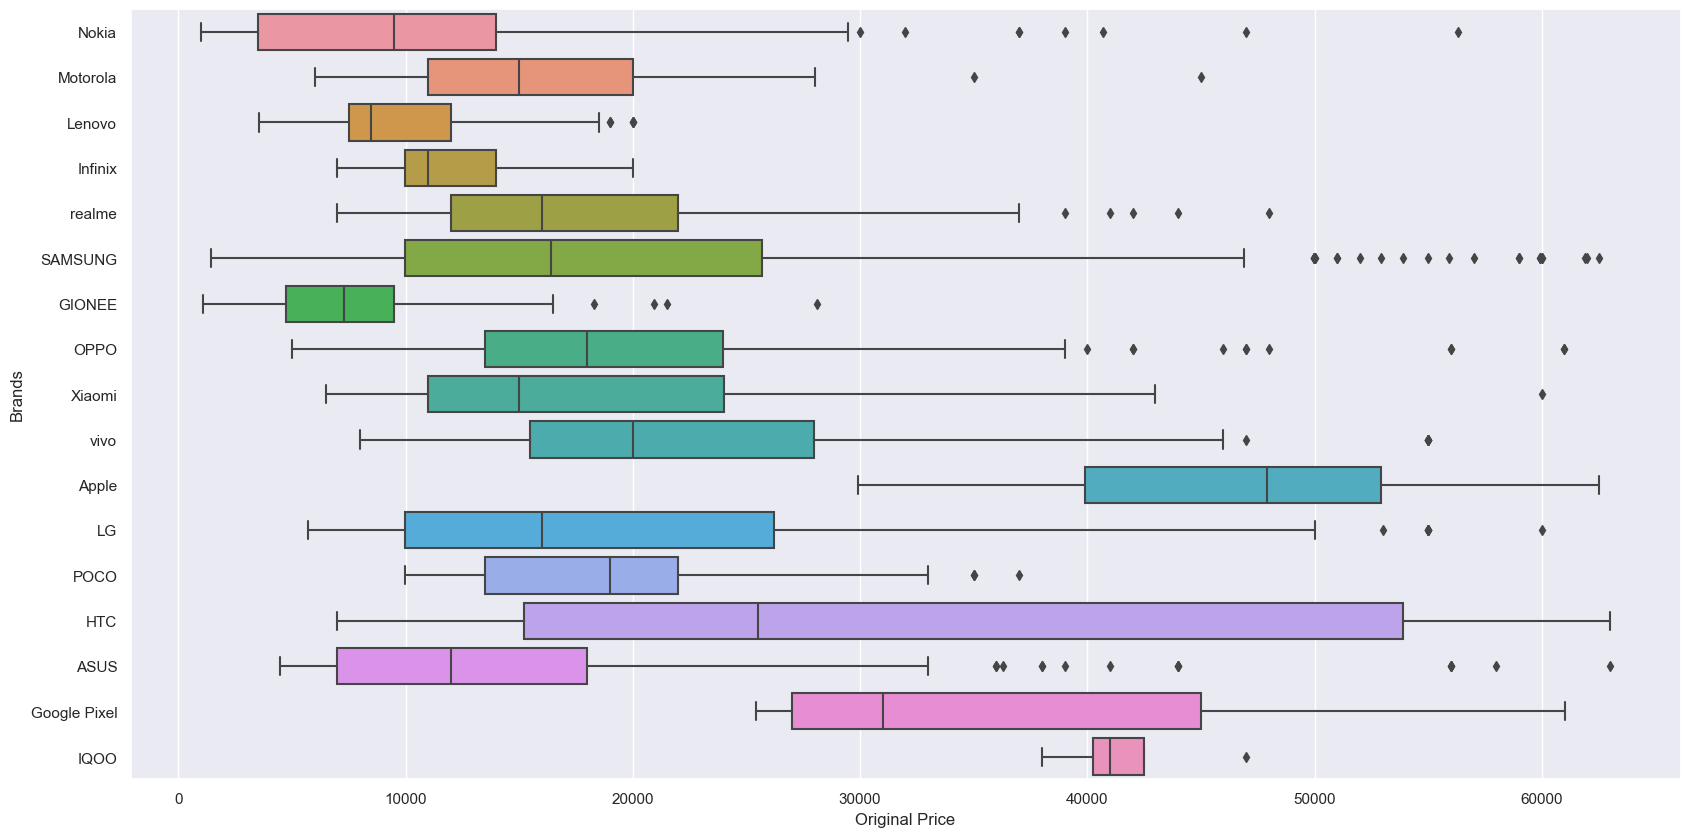

In [756]:
originalPrice = pd.DataFrame(filtered_data['Original Price'])
brands = pd.DataFrame(filtered_data['Brands'])

originalPrice_train, originalPrice_test, brands_train, brands_test = train_test_split(originalPrice, brands, test_size = 0.2)

joint = pd.concat([originalPrice_train, brands_train], axis=1).reindex(originalPrice_train.index)

f = plt.figure(figsize=(20,10))
sb.boxplot(x="Original Price", y="Brands", data = joint, orient="h")

<Axes: xlabel='Original Price', ylabel='Brands'>

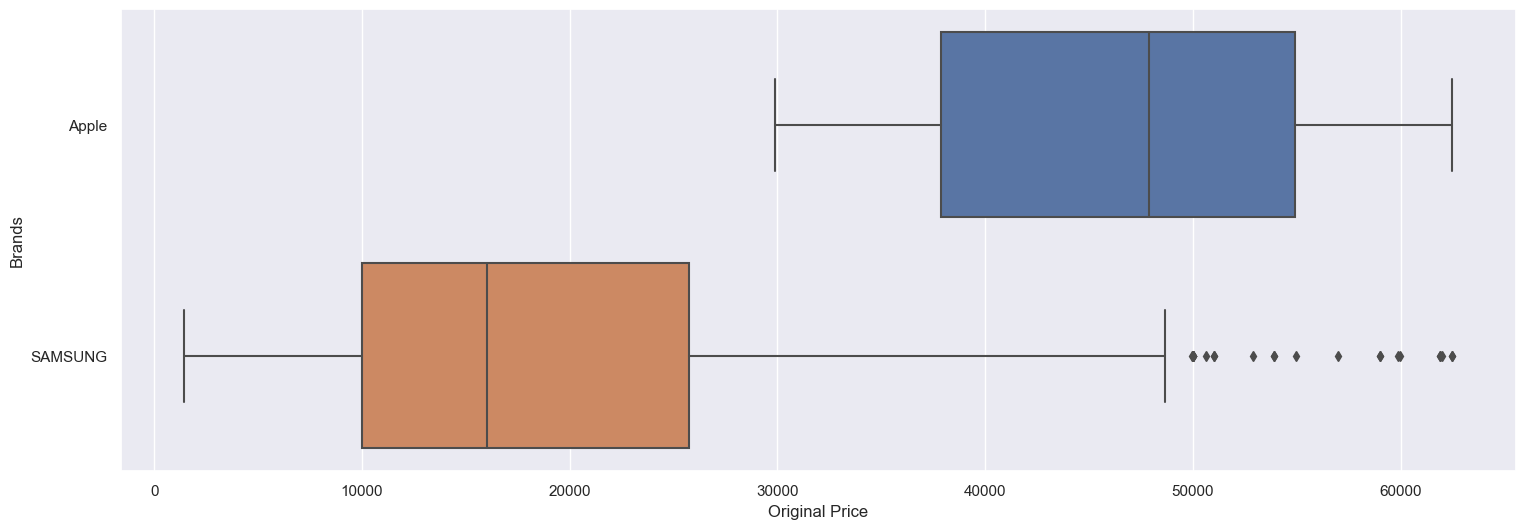

In [757]:
df = pd.DataFrame(filtered_data) 

df_filtered = df[(df['Brands'] == 'Apple') | (df['Brands'] == 'SAMSUNG')]

originalPrice = df_filtered[['Original Price']] #Predictor
brands = df_filtered['Brands'] #Response

originalPrice_train, originalPrice_test, brands_train, brands_test = train_test_split(originalPrice, brands, test_size = 0.2)

joint = pd.concat([originalPrice_train, brands_train], axis = 1).reindex(originalPrice_train.index)
f = plt.figure(figsize=(18,6))
sb.boxplot(x='Original Price', y ='Brands', data = joint, orient="h")

C:\Users\fonga\AppData\Local\Temp\ipykernel_6200\656596939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Brands'] = label_encoder.fit_transform(df_filtered['Brands'])


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8898026315789473
True postive rate 		: 0.9490835030549898
False positive rate 		: 0.358974358974359

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9150326797385621
True postive rate 		: 0.9586776859504132
False positive rate 		: 0.25



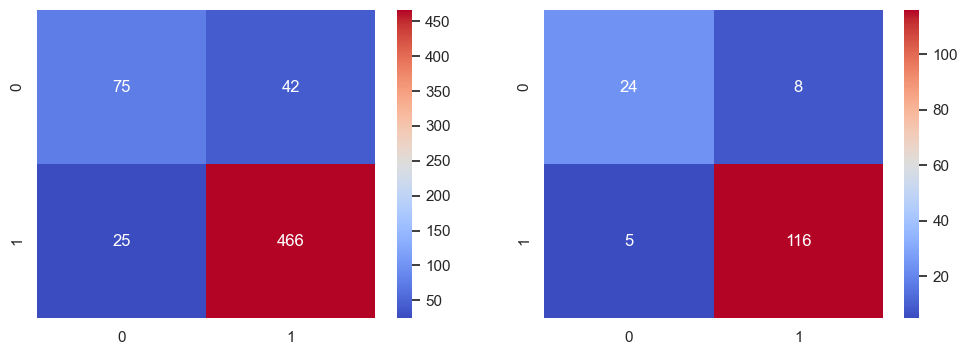

In [775]:
label_encoder = LabelEncoder()
df_filtered['Brands'] = label_encoder.fit_transform(df_filtered['Brands'])

##Depth 3
dectree = DecisionTreeClassifier(max_depth=3)
dectree.fit(originalPrice_train, brands_train)

#Predict the smartphone brand
brand_train_pred = dectree.predict(originalPrice_train)
brand_test_pred = dectree.predict(originalPrice_test)

cm_train = confusion_matrix(brands_train, brand_train_pred)
cm_test = confusion_matrix(brands_test, brand_test_pred)

tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(cm_train, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax = axes[0])
sb.heatmap(cm_test, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax = axes[1])

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(originalPrice_train, brands_train))
print("True postive rate \t\t:", (tp_train/(tp_train+fn_train)))
print("False positive rate \t\t:", (fp_train/(tn_train+fp_train)))
print()


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(originalPrice_test, brands_test))
print("True postive rate \t\t:", (tp_test/(tp_test+fn_test)))
print("False positive rate \t\t:", (fp_test/(tn_test+fp_test)))
print()

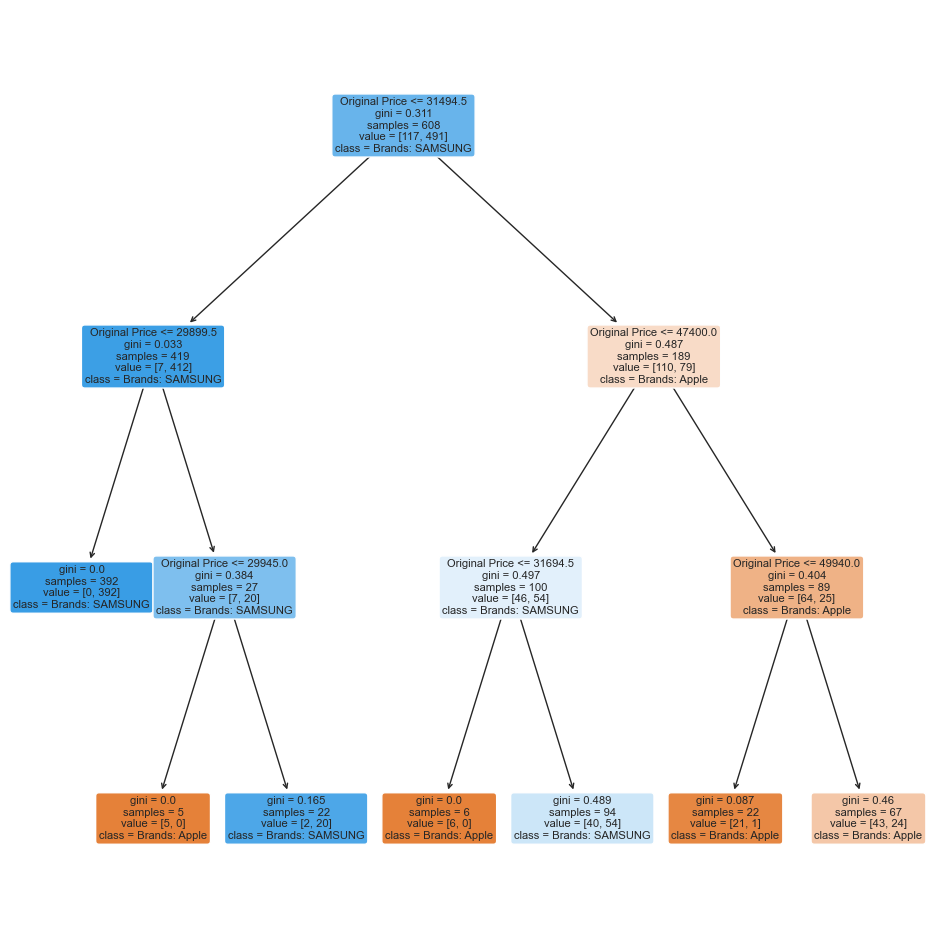

In [776]:
# Plot the trained Decision Tree
f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=["Original Price"], 
          class_names=["Brands: Apple","Brands: SAMSUNG"])
plt.show()